In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import cv2

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.utils.data import DataLoader
import albumentations as album 
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as T
from torchsummary import summary

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [4]:
DATA_DIR = '/content/drive/MyDrive/BTP/ChangeDataset'

x_train_dir_a = os.path.join(DATA_DIR, 'train/A')
x_train_dir_b = os.path.join(DATA_DIR, 'train/B')
y_train_dir = os.path.join(DATA_DIR, 'train/label')

x_val_dir_a = os.path.join(DATA_DIR, 'val/A')
x_val_dir_b = os.path.join(DATA_DIR, 'val/B')
y_val_dir = os.path.join(DATA_DIR, 'val/label')

x_test_dir_a = os.path.join(DATA_DIR, 'test/A')
x_test_dir_b = os.path.join(DATA_DIR, 'test/B')
y_test_dir = os.path.join(DATA_DIR, 'test/label')

In [5]:
transform = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224))      
])

In [6]:
class ChangeDataset(torch.utils.data.Dataset):

    def __init__(
        self, 
        images_a_dir, 
        images_b_dir,
        labels_dir,
        transforms=None,
        size=None,
    ):
        self.image_a_paths = [os.path.join(images_a_dir, image_id) for image_id in sorted(os.listdir(images_a_dir))][:size]
        self.image_b_paths = [os.path.join(images_b_dir, image_id) for image_id in sorted(os.listdir(images_b_dir))][:size]
        self.label_paths = [os.path.join(labels_dir, image_id) for image_id in sorted(os.listdir(labels_dir))][:size]
        self.transforms = transforms
    def __getitem__(self, i):
        
        # read images and masks
        image_a = cv2.cvtColor(cv2.imread(self.image_a_paths[i]), cv2.COLOR_BGR2RGB)
        image_b = cv2.cvtColor(cv2.imread(self.image_b_paths[i]), cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(cv2.imread(self.label_paths[i]), cv2.COLOR_BGR2GRAY)
        
        if self.transforms:
            image_a = self.transforms(image_a)
            image_b = self.transforms(image_b)
            label = self.transforms(label)

        return {'image1': image_a, 'image2':image_b, 'mask':label}

    def __len__(self):
        return len(self.image_a_paths)

In [7]:
changeData = ChangeDataset(x_train_dir_a, x_train_dir_b, y_train_dir, transform)
changeData2 = ChangeDataset(x_train_dir_a, x_train_dir_b, y_train_dir)

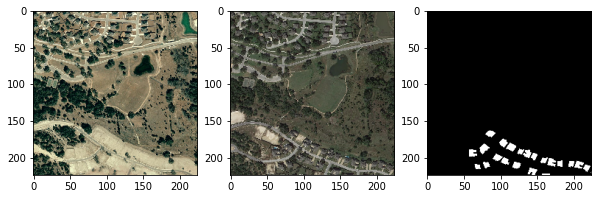

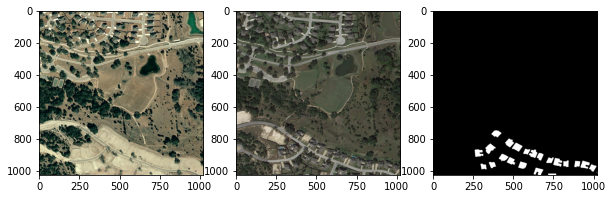

In [8]:
set1 = changeData[0]
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(set1['image1'].detach().permute(1, 2, 0))
plt.subplot(132)
plt.imshow(set1['image2'].detach().permute(1, 2, 0))
plt.subplot(133)
plt.imshow(set1['mask'].detach().permute(1, 2, 0).reshape((224, 224)), cmap='gray')
plt.show()

set1 = changeData2[0]
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(set1['image1'])
plt.subplot(132)
plt.imshow(set1['image2'])
plt.subplot(133)
plt.imshow(set1['mask'], cmap='gray')
plt.show()

In [9]:
def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0.0, mode='fan_in')
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
        init.constant_(m.bias.data, 0.0)

In [10]:
class UpSamplePipe(nn.Module):
    def __init__(self, in_channels, upLayers):
        super(UpSamplePipe, self).__init__()

        self.convl2 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1, stride=1, bias=False)
        upSeq = []
        for i in range(upLayers):
            upSeq.append(nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1, dilation=1, bias=False))

        self.upconvl2 = nn.Sequential(*upSeq)
        # self.upconvl2 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=stride, padding=padding, dilation=dilation, bias=False)
        self.bnl2 = nn.BatchNorm2d(32)
        self.rel = nn.ReLU()
        
    def forward(self, x):
        x = self.convl2(x)
        x = self.upconvl2(x)
        x = self.bnl2(x)
        x = self.rel(x)
        return x

In [11]:
class ChangeNet(nn.Module):
    def __init__(self):
        super(ChangeNet, self).__init__()

        self.outlets = ['layer2', 'layer3', 'layer4']
        self.resBackbone = models.resnet50(pretrained=True)
        for param in self.resBackbone.parameters():
            param.requires_grad = False

        self.pipel2 = UpSamplePipe(in_channels=512, upLayers=3)
        self.pipel3 = UpSamplePipe(in_channels=1024, upLayers=4)
        self.pipel4 = UpSamplePipe(in_channels=2048, upLayers=5)

        self.conCat1 = nn.Conv2d(in_channels=32*3, out_channels=1, kernel_size=1, stride=1, bias=False)
        self.conCat2 = nn.Conv2d(in_channels=32*3, out_channels=1, kernel_size=1, stride=1, bias=False)
        # for model v2
        # self.afConv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1, stride=1, bias=False)
        #
        self.sigmoid = nn.Sigmoid()

        self.pipel2.apply(init_weight)
        self.pipel3.apply(init_weight)
        self.pipel4.apply(init_weight)
        self.conCat1.apply(init_weight)
        self.conCat2.apply(init_weight)

    def resforward(self, x):
        skipFeatures = {}
        for name, child in self.resBackbone.named_children():
            if name == 'layer4':
                x = child(x)
                skipFeatures['layer4'] = x
                break
            else:
                x = child(x)
                if name in self.outlets:
                    skipFeatures[name] = x
        return skipFeatures
    
    def forward(self, image1, image2):

        im1_skips = self.resforward(image1)
        im2_skips = self.resforward(image2)
        
        x1l2 = self.pipel2(im1_skips['layer2'])
        x2l2 = self.pipel2(im2_skips['layer2'])

        x1l3 = self.pipel3(im1_skips['layer3'])
        x2l3 = self.pipel3(im2_skips['layer3'])

        x1l4 = self.pipel4(im1_skips['layer4'])
        x2l4 = self.pipel4(im2_skips['layer4'])

        x1con = torch.cat([x1l2, x1l3, x1l4], dim=1)
        # del x1l2, x1l3, x1l4
        x2con = torch.cat([x2l2, x2l3, x2l4], dim=1)
        # del x2l2, x2l3, x2l4
        
        x1con = self.conCat1(x1con)
        x2con = self.conCat2(x2con)

        x1x2 = x1con + x2con
        # for model v2
        # x1x2 = torch.cat([x1con, x2con], dim=1)
        # x1x2 = self.afConv(x1x2)
        #
        x1x2 = self.sigmoid(x1x2)

        return x1x2


In [12]:
def validate(model, loader, criterion, device):
    model.eval()
    n_val = len(loader)
    tot = 0
    n = 0
    with tqdm(total=n_val, desc='Validation', unit='batch') as pbar:
        for batch in loader:
            img1, img2, mask = batch['image1'], batch['image2'], batch['mask']
            img1 = img1.to(device=device, dtype=torch.float32)
            img2 = img2.to(device=device, dtype=torch.float32)
            mask = mask.to(device=device, dtype=torch.float32)
            
            with torch.no_grad():
                label = model(img1, img2)
            
            tot += criterion(label, mask).item()
            pbar.update()
            n+=1
    
    model.train()
    return tot/n

In [13]:
# Training
checkpointDir = '/content/drive/MyDrive/BTP'

def training(model, optimizer, scheduler, epochs, trainLoader, valLoader, device):
    
    criterionTrain = smp.utils.losses.DiceLoss()
    criterionVal = smp.utils.metrics.IoU(threshold=0.5)
    # criterionTrain = nn.BCELoss()
    # criterionVal = nn.BCELoss()

    validate(model, valLoader, criterionVal, device)
    
    n_train = len(trainLoader)
    
    val_best = 0.0
    for epoch in range(epochs):
        model.train()
        i = 0
        running_loss = 0
        optimizer.zero_grad()
        with tqdm(total=n_train, desc=f'Epochs {epoch+1}/{epochs}', unit='batch') as pbar:
            for batch in trainLoader:
                val_score = 0
                i+=1
                img1, img2 = batch['image1'], batch['image2']
                mask = batch['mask']

                img1 = img1.to(device=device, dtype=torch.float32)
                img2 = img2.to(device=device, dtype=torch.float32)
                mask = mask.to(device=device, dtype=torch.float32)

                labels = model(img1, img2)

                loss = criterionTrain(labels, mask)
                IoUscore = criterionVal(labels, mask)

                running_loss += loss.item()

                pbar.set_postfix(**{'loss': running_loss/i, 'DICELoss': loss.item(), 'IoU score':IoUscore.item()}) 

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                pbar.update(1)
            
            val_score = validate(model, valLoader, criterionVal, device)
            scheduler.step()
            if val_score > val_best:
                val_best = val_score
                torch.save(model.state_dict(), os.path.join(checkpointDir, 'change_100ep_best.pth'))
                print('Best Model Saved!!')

        TRAIN_hist.append(running_loss/i)
        VAL_hist.append(val_score)       


In [14]:
# Get train and val dataset instances
BATCHSIZE = 16
train_dataset = ChangeDataset(
    x_train_dir_a, x_train_dir_b, y_train_dir, transform
)

valid_dataset = ChangeDataset(
    x_val_dir_a, x_val_dir_b, y_val_dir, transform
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [15]:
# Set num of epochs
EPOCHS = 100

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChangeNet()
model = model.to(device=DEVICE)
# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
print(DEVICE)

cuda


In [17]:
TRAIN_hist = []
VAL_hist = []
torch.cuda.empty_cache()
training(model, optimizer, lr_scheduler, EPOCHS, train_loader, valid_loader, DEVICE)

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 1/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 2/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 3/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 4/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 5/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 6/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 7/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 8/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 9/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 10/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 11/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 12/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 13/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 14/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 15/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 16/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 17/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 18/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Best Model Saved!!


Epochs 19/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 20/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 21/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 22/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 23/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 24/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 25/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 26/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 27/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 28/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 29/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 30/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 31/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 32/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 33/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 34/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 35/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 36/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 37/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 38/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 39/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 40/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 41/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 42/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 43/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 44/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 45/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 46/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 47/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 48/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 49/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 50/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 51/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 52/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 53/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 54/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 55/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 56/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 57/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 58/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 59/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 60/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 61/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 62/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 63/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 64/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 65/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 66/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 67/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 68/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 69/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 70/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 71/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 72/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 73/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 74/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 75/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 76/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 77/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 78/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 79/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 80/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 81/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 82/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 83/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 84/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 85/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 86/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 87/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 88/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 89/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 90/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 91/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 92/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 93/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 94/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 95/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 96/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 97/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 98/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 99/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

Epochs 100/100:   0%|          | 0/28 [00:00<?, ?batch/s]

Validation:   0%|          | 0/64 [00:00<?, ?batch/s]

In [19]:
torch.save(model.state_dict(), '/content/drive/MyDrive/BTP/change_100ep_final.pth')

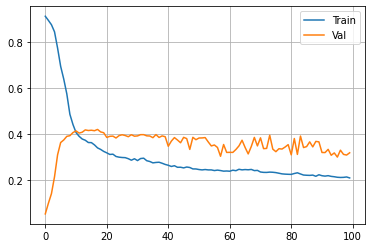

In [20]:
plt.figure()
plt.plot(TRAIN_hist)
plt.plot(VAL_hist)
plt.legend(["Train", "Val"])
plt.grid(True)
plt.show()

In [21]:
testData = ChangeDataset(x_test_dir_a, x_test_dir_b, y_test_dir, transform)

In [22]:
test_loader = DataLoader(testData, batch_size=1)

In [23]:
best_model = ChangeNet().to(DEVICE)

In [25]:
best_model.load_state_dict(torch.load('/content/drive/MyDrive/BTP/change_100ep_best.pth', map_location=DEVICE))
# best_model.load_state_dict(torch.load('/content/drive/MyDrive/BTP/change_mulup_40ep.pth', map_location=DEVICE))
best_model.eval()
testIOU = 0
testDice = 0
criterionTest = smp.utils.metrics.IoU(threshold=0.5)
criterionDice = smp.utils.losses.DiceLoss()
i=0
for seti in test_loader:
    i+=1
    img1 = seti['image1'].to(device=DEVICE)
    img2 = seti['image2'].to(device=DEVICE)
    mask = seti['mask'].to(device=DEVICE)
    label = best_model(img1, img2)
    testIOU += criterionTest(mask, label).item()
    testDice += criterionDice(mask, label).item()
    # plt.figure(figsize=(16, 6))
    # plt.subplot(141)
    # plt.title("Image A")
    # plt.imshow(img1[0].to('cpu').detach().permute(1, 2, 0))
    # plt.subplot(142)
    # plt.title("Image B")
    # plt.imshow(img2[0].to('cpu').detach().permute(1, 2, 0))
    # plt.subplot(143)
    # plt.title("GT")
    # plt.imshow(mask[0].to('cpu').detach().permute(1, 2, 0).reshape((224, 224)), cmap='gray')
    # plt.subplot(144)
    # plt.title("Prediction")
    # plt.imshow(label[0].to('cpu').detach().permute(1, 2,0).reshape((224, 224)), cmap='gray')
    # plt.savefig('/content/drive/MyDrive/BTP/changePreds_changeNet_100_bce/pred_100ep_{}.png'.format(i))

print("TestIOU : {}".format(testIOU/i))
print("TestDice : {}".format(testDice/i))

TestIOU : 0.3159592512163242
TestDice : 0.5525180837139487
